# Isolated Sign Language Recognition using Sequence Model

## Introduction

This project aims to develop an isolated sign language recognition
model that can identify signs made in landmark data extracted from raw videos
of sign language gestures. The model will be trained using a combination of
LSTM and GRU network and evaluated based on its accuracy in identifying the
correct sign gestures.

This notebook is created for [Kaggle's Sign Langueage Classifier Competition](https://www.kaggle.com/competitions/asl-signs/code)



- I used the preprocessed tensorflow Dataset from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).




<a id="section-one"></a>
## Import Libraries and Set File Directories

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Activation, Dropout, LSTM, GRU
from tensorflow.keras import Model
from keras.utils.vis_utils import plot_model

In [ ]:
# set files directories
LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"

<a id="section-three"></a>
## Load Data

In [ ]:
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE +POSE
len(POINT_LANDMARKS)

126

In [ ]:

DATA_PATH = "/kaggle/input/saved-tfdataset-of-google-isl-recognition-data/GoogleISLDatasetBatched"
N_SIGNS = 250
ROWS_PER_FRAME = 543

To keep it simple, we will use the preprocessed [tf.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).

In [ ]:
def preprocess(ragged_batch, labels):
    ragged_batch = tf.gather(ragged_batch, POINT_LANDMARKS, axis=2)
    ragged_batch = tf.where(tf.math.is_nan(ragged_batch), tf.zeros_like(ragged_batch), ragged_batch)
    return tf.concat([ragged_batch[...,i] for i in range(3)],-1) , labels



In [ ]:
dataset = tf.data.Dataset.load(DATA_PATH)
dataset = dataset.map(preprocess)

# Split into train, validation, and test sets
test_size = int(0.10 * len(dataset))
val_size = int(0.10 * len(dataset))
train_size = len(dataset) - val_size -test_size

test_ds = dataset.take(test_size).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(test_size).take(val_size).cache().prefetch(tf.data.AUTOTUNE)
train_ds = dataset.skip(val_size + test_size).cache().shuffle(20).prefetch(tf.data.AUTOTUNE)


In [ ]:
for x, y in train_ds.take(1):
    print(x.shape)
    print(y.shape)

(512, None, 378)
(512, 1)


In [ ]:
y_test = []
for batch in test_ds:
    # Extract the features and labels
    features, labels = batch
    for label in labels:
        y_test.append(label)


In [ ]:
y_test = np.array(y_test).squeeze().flatten()
y_test

array([ 25, 232,  48, ...,  90,  11, 200])

In [ ]:
import json
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')

print(train.head())

k = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')
sign_to_prediction_index_map = json.load(k)
prediction_to_sign_map = {}
for i, j in sign_to_prediction_index_map.items():
    prediction_to_sign_map[j]=i



ROWS_PER_FRAME = 543  # number of landmarks per frame

                                            path  participant_id  sequence_id  \
0  train_landmark_files/26734/1000035562.parquet           26734   1000035562   
1  train_landmark_files/28656/1000106739.parquet           28656   1000106739   
2   train_landmark_files/16069/100015657.parquet           16069    100015657   
3  train_landmark_files/25571/1000210073.parquet           25571   1000210073   
4  train_landmark_files/62590/1000240708.parquet           62590   1000240708   

    sign  
0   blow  
1   wait  
2  cloud  
3   bird  
4   owie  


In [ ]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

<a id="section-four"></a>
## Modeling

Now let us get to the fun part, training the model!

In [ ]:
# include early stopping and reducelr
checkpoint_filepath = '/tmp/checkpoint'
def get_callbacks():
    return [
            tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.1,
            patience = 3
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
    ]



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 378)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 512)         1824768   
                                                                 
 drop1 (Dropout)             (None, None, 512)         0         
                                                                 
 gru (GRU)                   (None, 512)               1575936   
                                                                 
 drop2 (Dropout)             (None, 512)               0         
                                                                 
 dense (Dense)               (None, 250)               128250    
                                                                 
Total params: 3,528,954
Trainable params: 3,528,954
Non-train

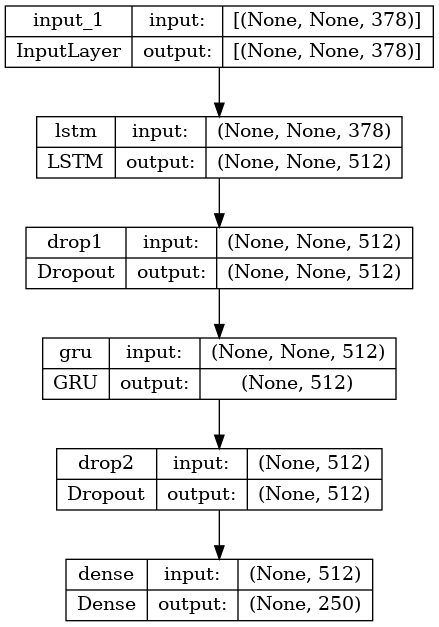

In [ ]:

# Define input layer
inputs = Input(shape=(None, 3 * len(POINT_LANDMARKS)), ragged=True)

# Define dense encoder model
x = inputs


# Define classifier model
lstm1 =LSTM(512, name="lstm", return_sequences=True)(x)
drop1 = Dropout(0.5, name="drop1")(lstm1)
lstm2 = GRU(512, name="gru")(drop1)
drop2 = Dropout(0.5, name="drop2")(lstm2)
out = Dense(N_SIGNS, activation="softmax", name="dense")(drop2)

# Define model
model = Model(inputs=inputs, outputs=out)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics= ["accuracy", "sparse_top_k_categorical_accuracy"])

In [ ]:
# fit the model with 100 epochs iteration
History =model.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks(),
          epochs = 100)

Epoch 1/100
149/149 [==============================] - 212s 1s/step - loss: 5.3571 - accuracy: 0.0108 - sparse_top_k_categorical_accuracy: 0.0496 - val_loss: 4.9628 - val_accuracy: 0.0281 - val_sparse_top_k_categorical_accuracy: 0.1166 - lr: 0.0010
Epoch 2/100
149/149 [==============================] - 49s 327ms/step - loss: 4.5141 - accuracy: 0.0714 - sparse_top_k_categorical_accuracy: 0.2247 - val_loss: 3.7544 - val_accuracy: 0.1776 - val_sparse_top_k_categorical_accuracy: 0.4310 - lr: 0.0010
Epoch 3/100
149/149 [==============================] - 48s 325ms/step - loss: 3.6423 - accuracy: 0.1800 - sparse_top_k_categorical_accuracy: 0.4456 - val_loss: 3.1564 - val_accuracy: 0.2746 - val_sparse_top_k_categorical_accuracy: 0.5625 - lr: 0.0010
Epoch 4/100
149/149 [==============================] - 48s 325ms/step - loss: 3.0408 - accuracy: 0.2882 - sparse_top_k_categorical_accuracy: 0.5849 - val_loss: 2.7041 - val_accuracy: 0.3562 - val_sparse_top_k_categorical_accuracy: 0.6590 - lr: 0.001

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.evaluate(test_ds)

18/18 [==============================] - 3s 178ms/step - loss: 1.2502 - accuracy: 0.7056 - sparse_top_k_categorical_accuracy: 0.8765


[1.2501513957977295, 0.7056206464767456, 0.8765190839767456]


## Classification Report

In [ ]:
y_test_pred = model.predict(test_ds, verbose=2).argmax(axis=1)
    # Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(250)]

18/18 - 52s - 52s/epoch - 3s/step


In [ ]:
y_test_prob = model.predict(test_ds, verbose=2)

18/18 - 3s - 3s/epoch - 169ms/step


In [ ]:
from sklearn.metrics import classification_report

def print_classification_report():
    # Classification report for all signs
    report = classification_report(
            y_test,
            y_test_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    report = pd.DataFrame(report).T
    report = report.round(2)
    report = report.astype({
            'support': np.uint16,
        })
    # Add signs
    report['sign'] = [e if e in SIGN2ORD else -1 for e in report.index]
    report['sign_ord'] = report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    report = pd.concat((
        report.head(250).sort_values('f1-score', ascending=False),
        report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(report)

In [ ]:
print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
brown,1.00,0.96,0.98,51,brown,31
callonphone,0.93,0.95,0.94,44,callonphone,34
sad,0.93,0.93,0.93,42,sad,189
radio,0.89,0.94,0.91,34,radio,182
police,0.94,0.88,0.91,33,police,174
drink,0.95,0.87,0.91,45,drink,63
yesterday,0.90,0.90,0.90,42,yesterday,245
find,0.89,0.91,0.90,43,find,78
first,0.86,0.94,0.90,34,first,83
gum,0.88,0.92,0.90,39,gum,103


## Computing the AUC for each class

In [ ]:
from sklearn.metrics import roc_auc_score

def calculate_auc():

    # Calculate AUC for each class
    auc_scores = []
    for class_idx in range(len(labels)):
        y_true = (y_test == class_idx).astype(int)
        y_pred = y_test_prob[:, class_idx]
        auc = roc_auc_score(y_true, y_pred, multi_class='ovo' )
        auc_scores.append(auc)

    # Round AUC scores for better readability
    auc_scores = [round(auc, 3) for auc in auc_scores]

    # Create a DataFrame to display AUC scores
    auc_report = pd.DataFrame({
        'Sign': labels,
        'AUC': auc_scores
    })

    # Sort DataFrame by AUC scores in descending order
    auc_report = auc_report.sort_values(by='AUC', ascending=False)
    display(auc_report)


In [ ]:
calculate_auc()

,Sign,AUC
25,blow,1.000
133,lion,1.000
78,find,1.000
83,first,1.000
32,bug,1.000
31,brown,1.000
29,boy,1.000
197,shower,1.000
242,wolf,1.000
194,shhh,1.000


## Plotting the Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))

    values = History.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(History.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = History.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()
    plt.savefig(metric + '.png')
    plt.show()

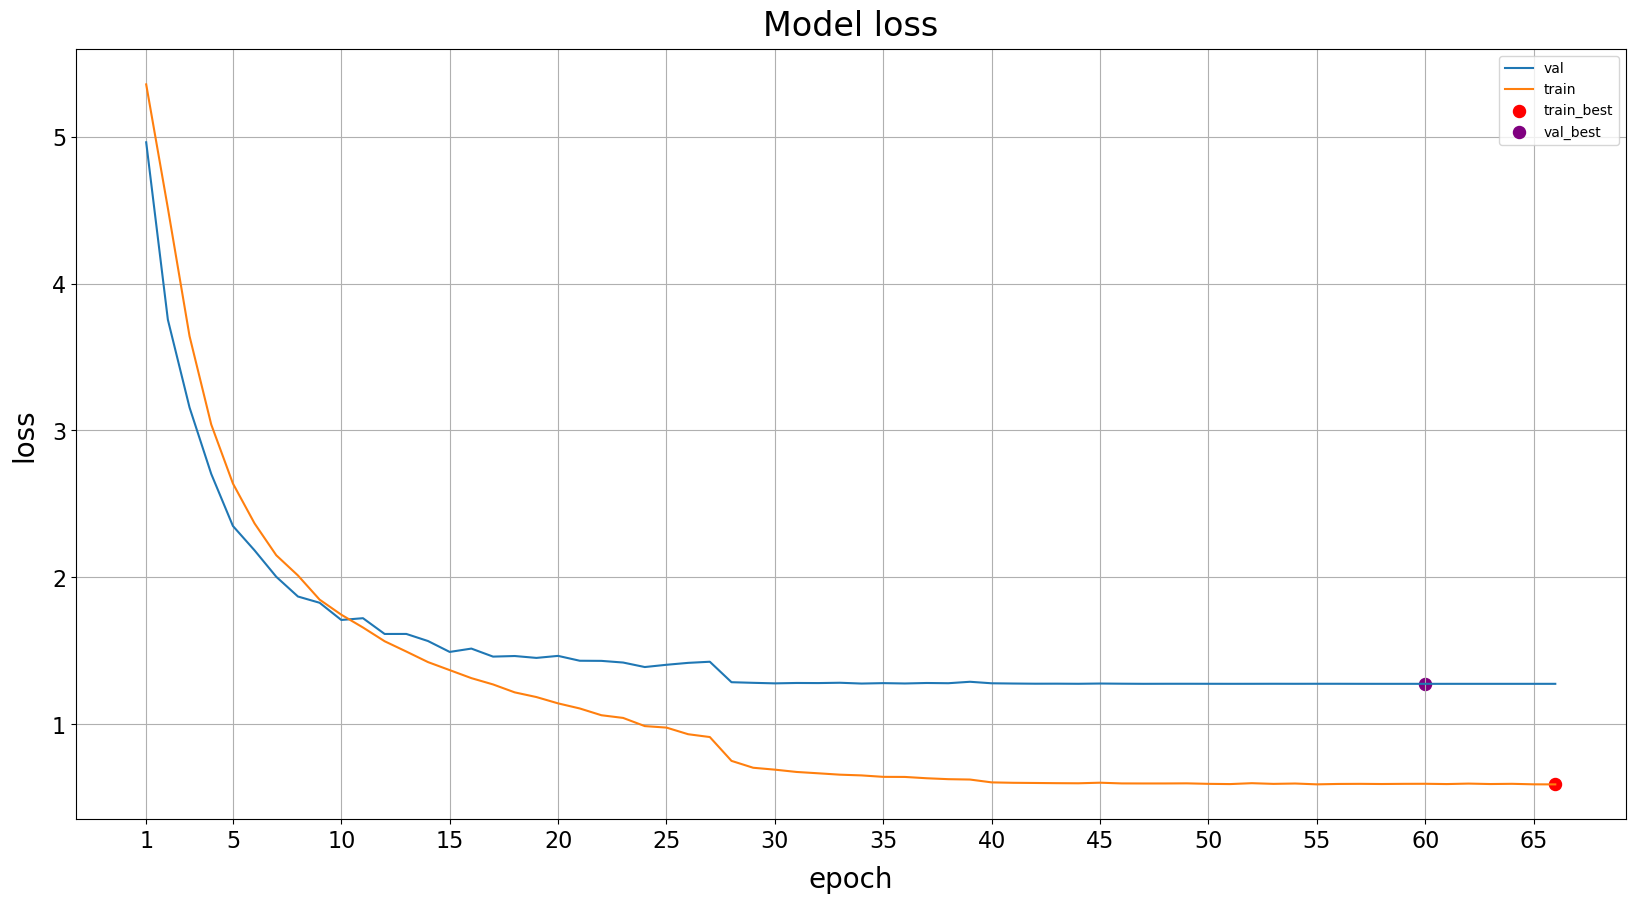

In [ ]:
plot_history_metric('loss', f_best=np.argmin)

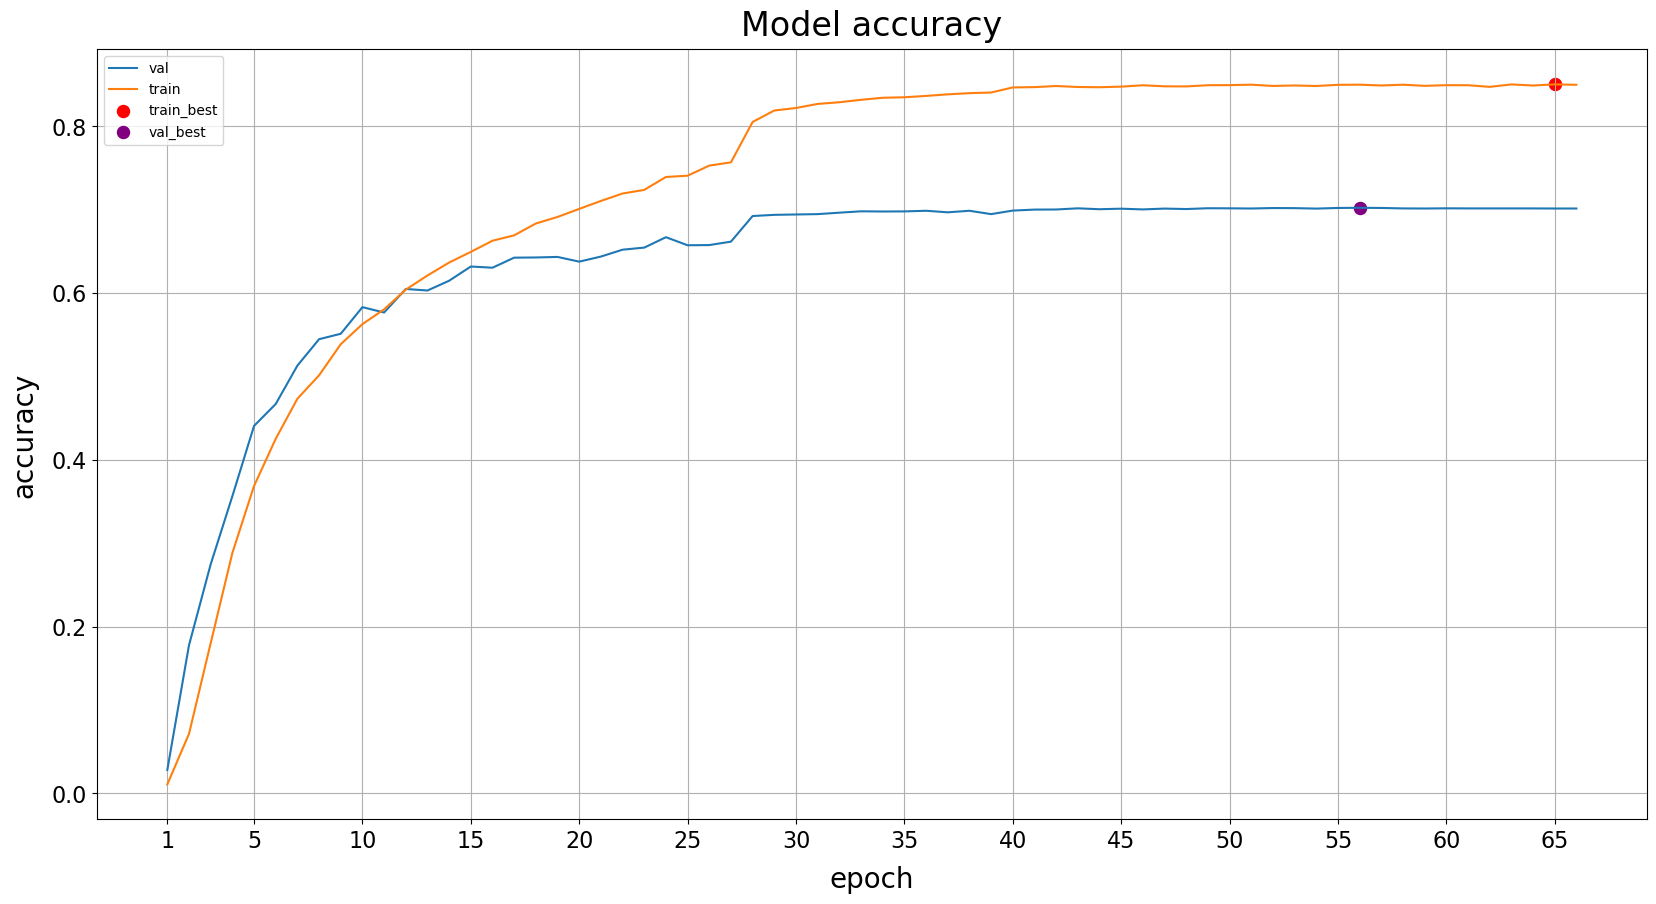

In [ ]:
plot_history_metric('accuracy', f_best=np.argmax)

## Confusion matrix
I went with two approaches to visualize the confusion matrix, the first one was to visualize all the classes which was ugly to see, afterward, I did a subset of the classes, it is more readable  but it doesnt give all the information about the misprediction.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix():


    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Create a list of class labels
    classes = range(len(labels))

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(30, 30))

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

    # Set labels, title, and tick parameters
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticks(classes,)
    ax.yaxis.set_ticks(classes)

    # Show the plot
    plt.show()


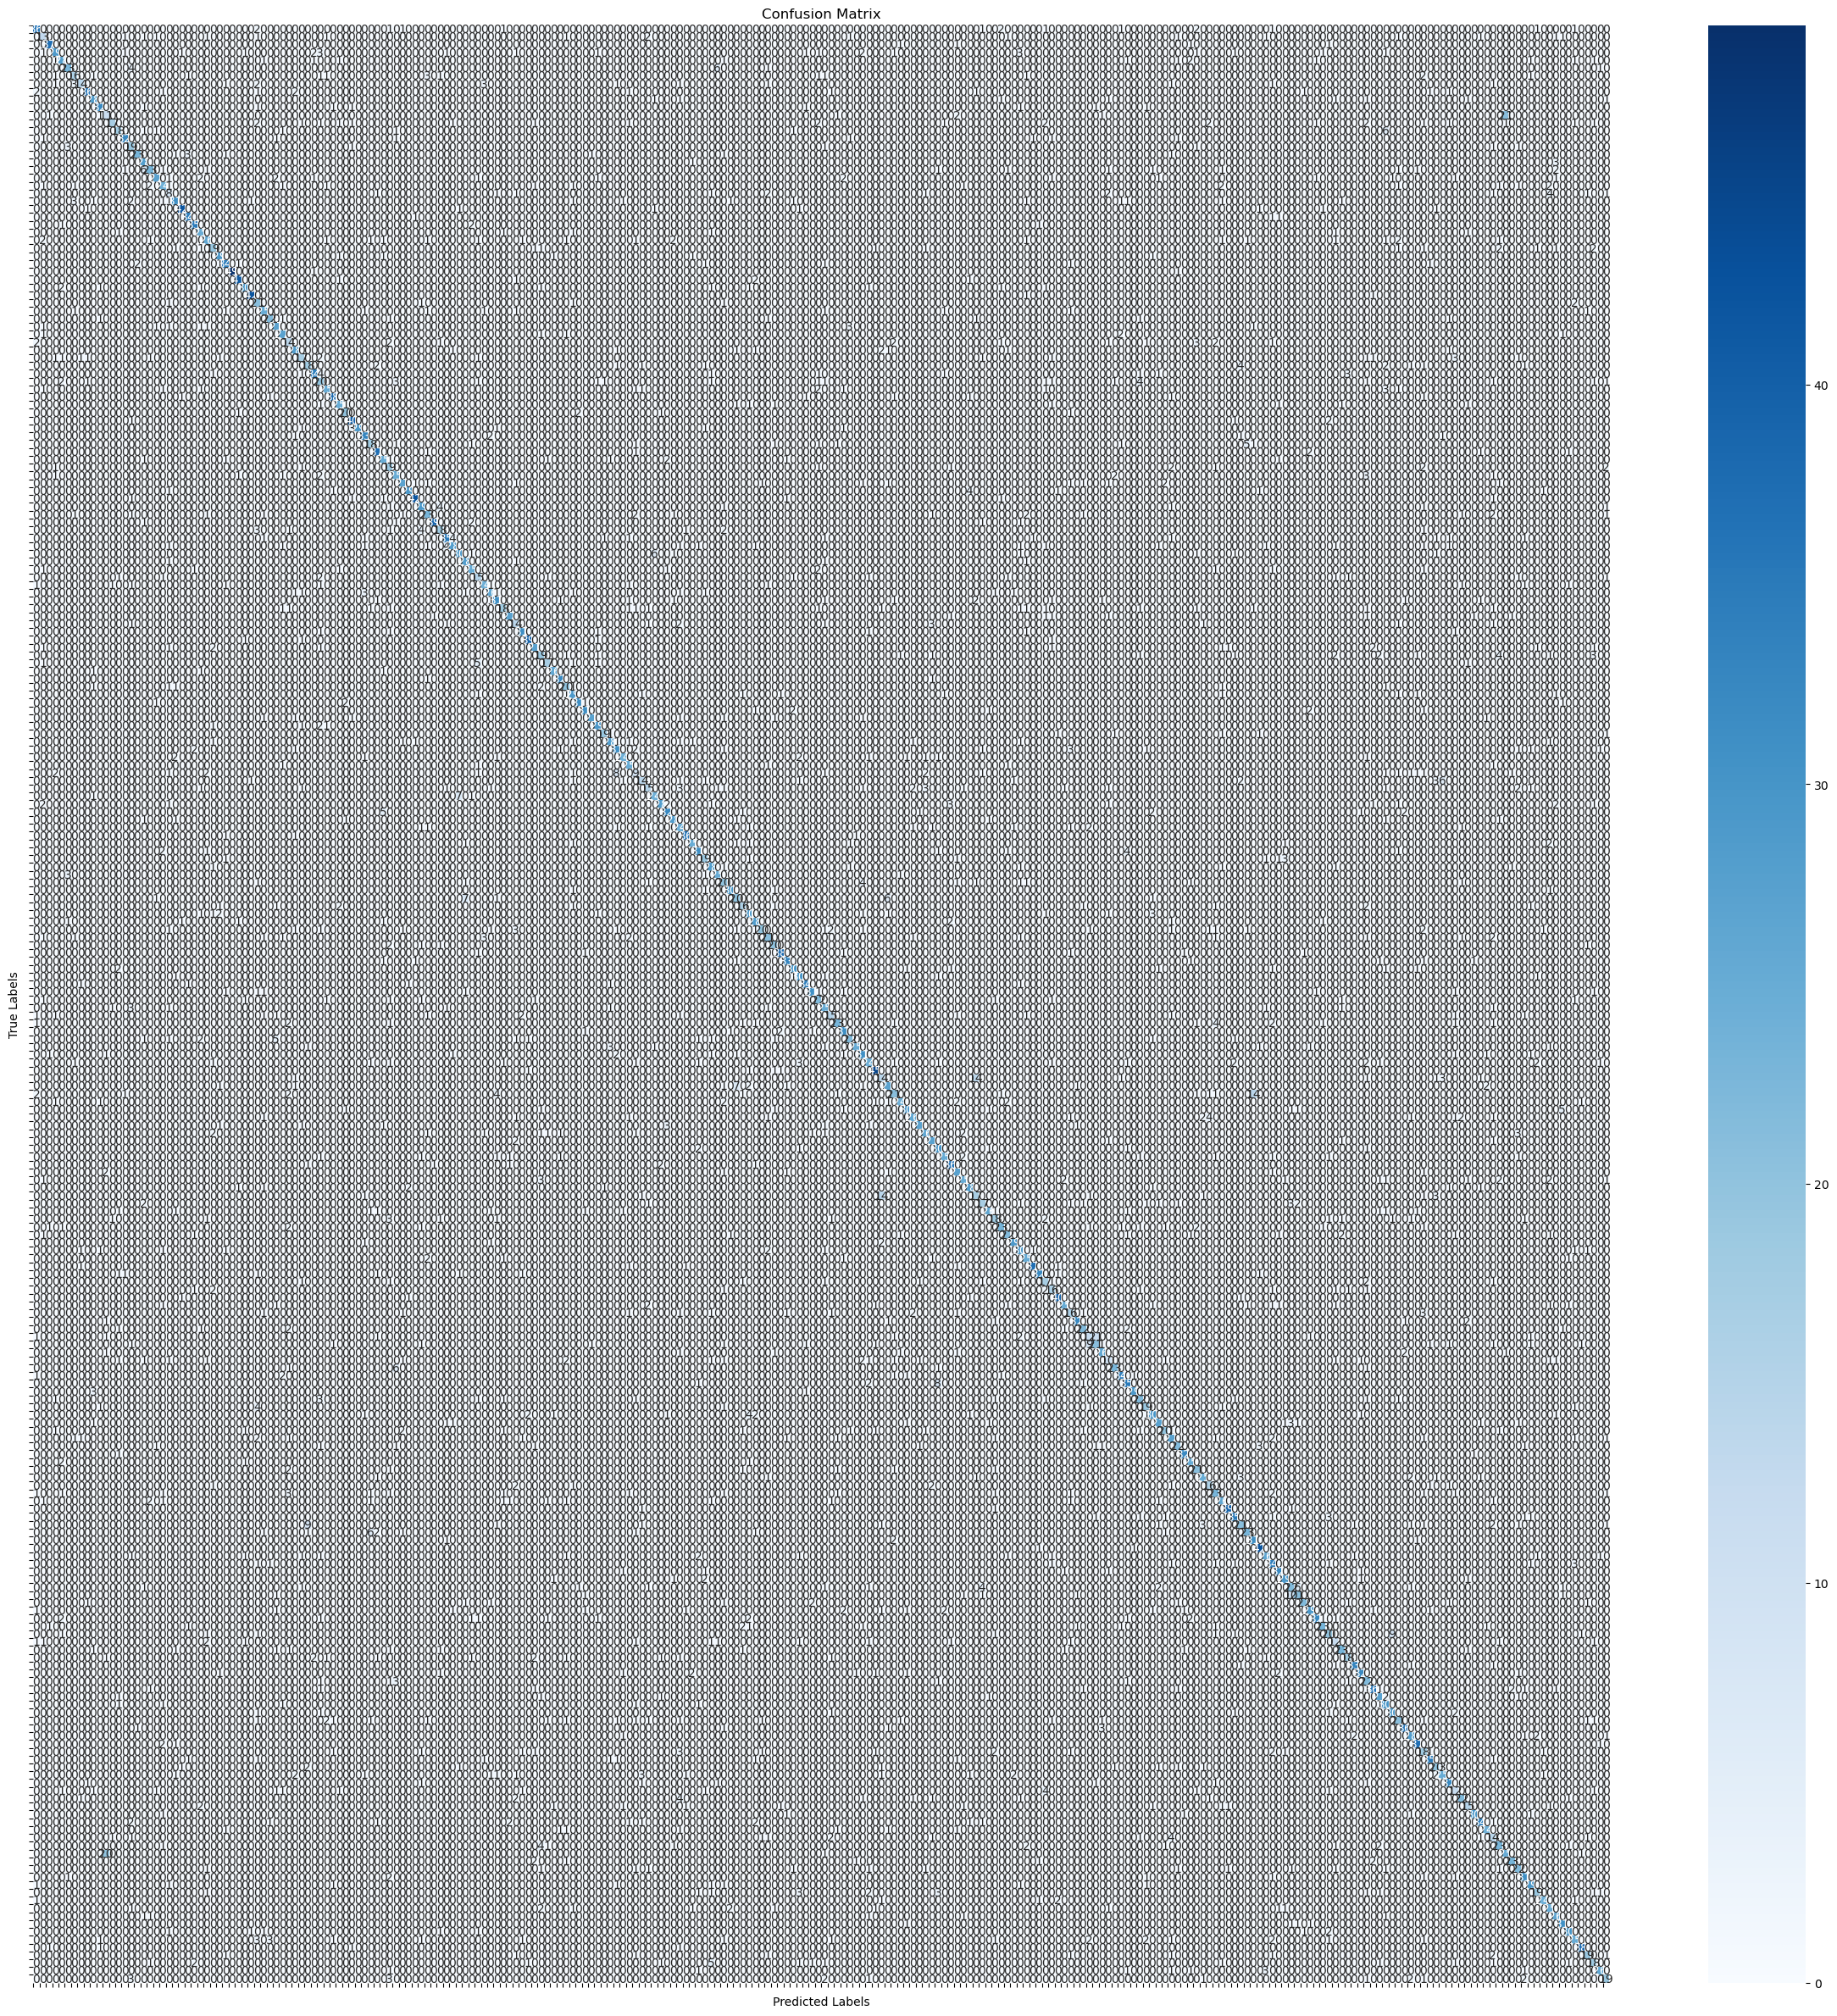

In [ ]:
plot_confusion_matrix()

18/18 [==============================] - 3s 171ms/step


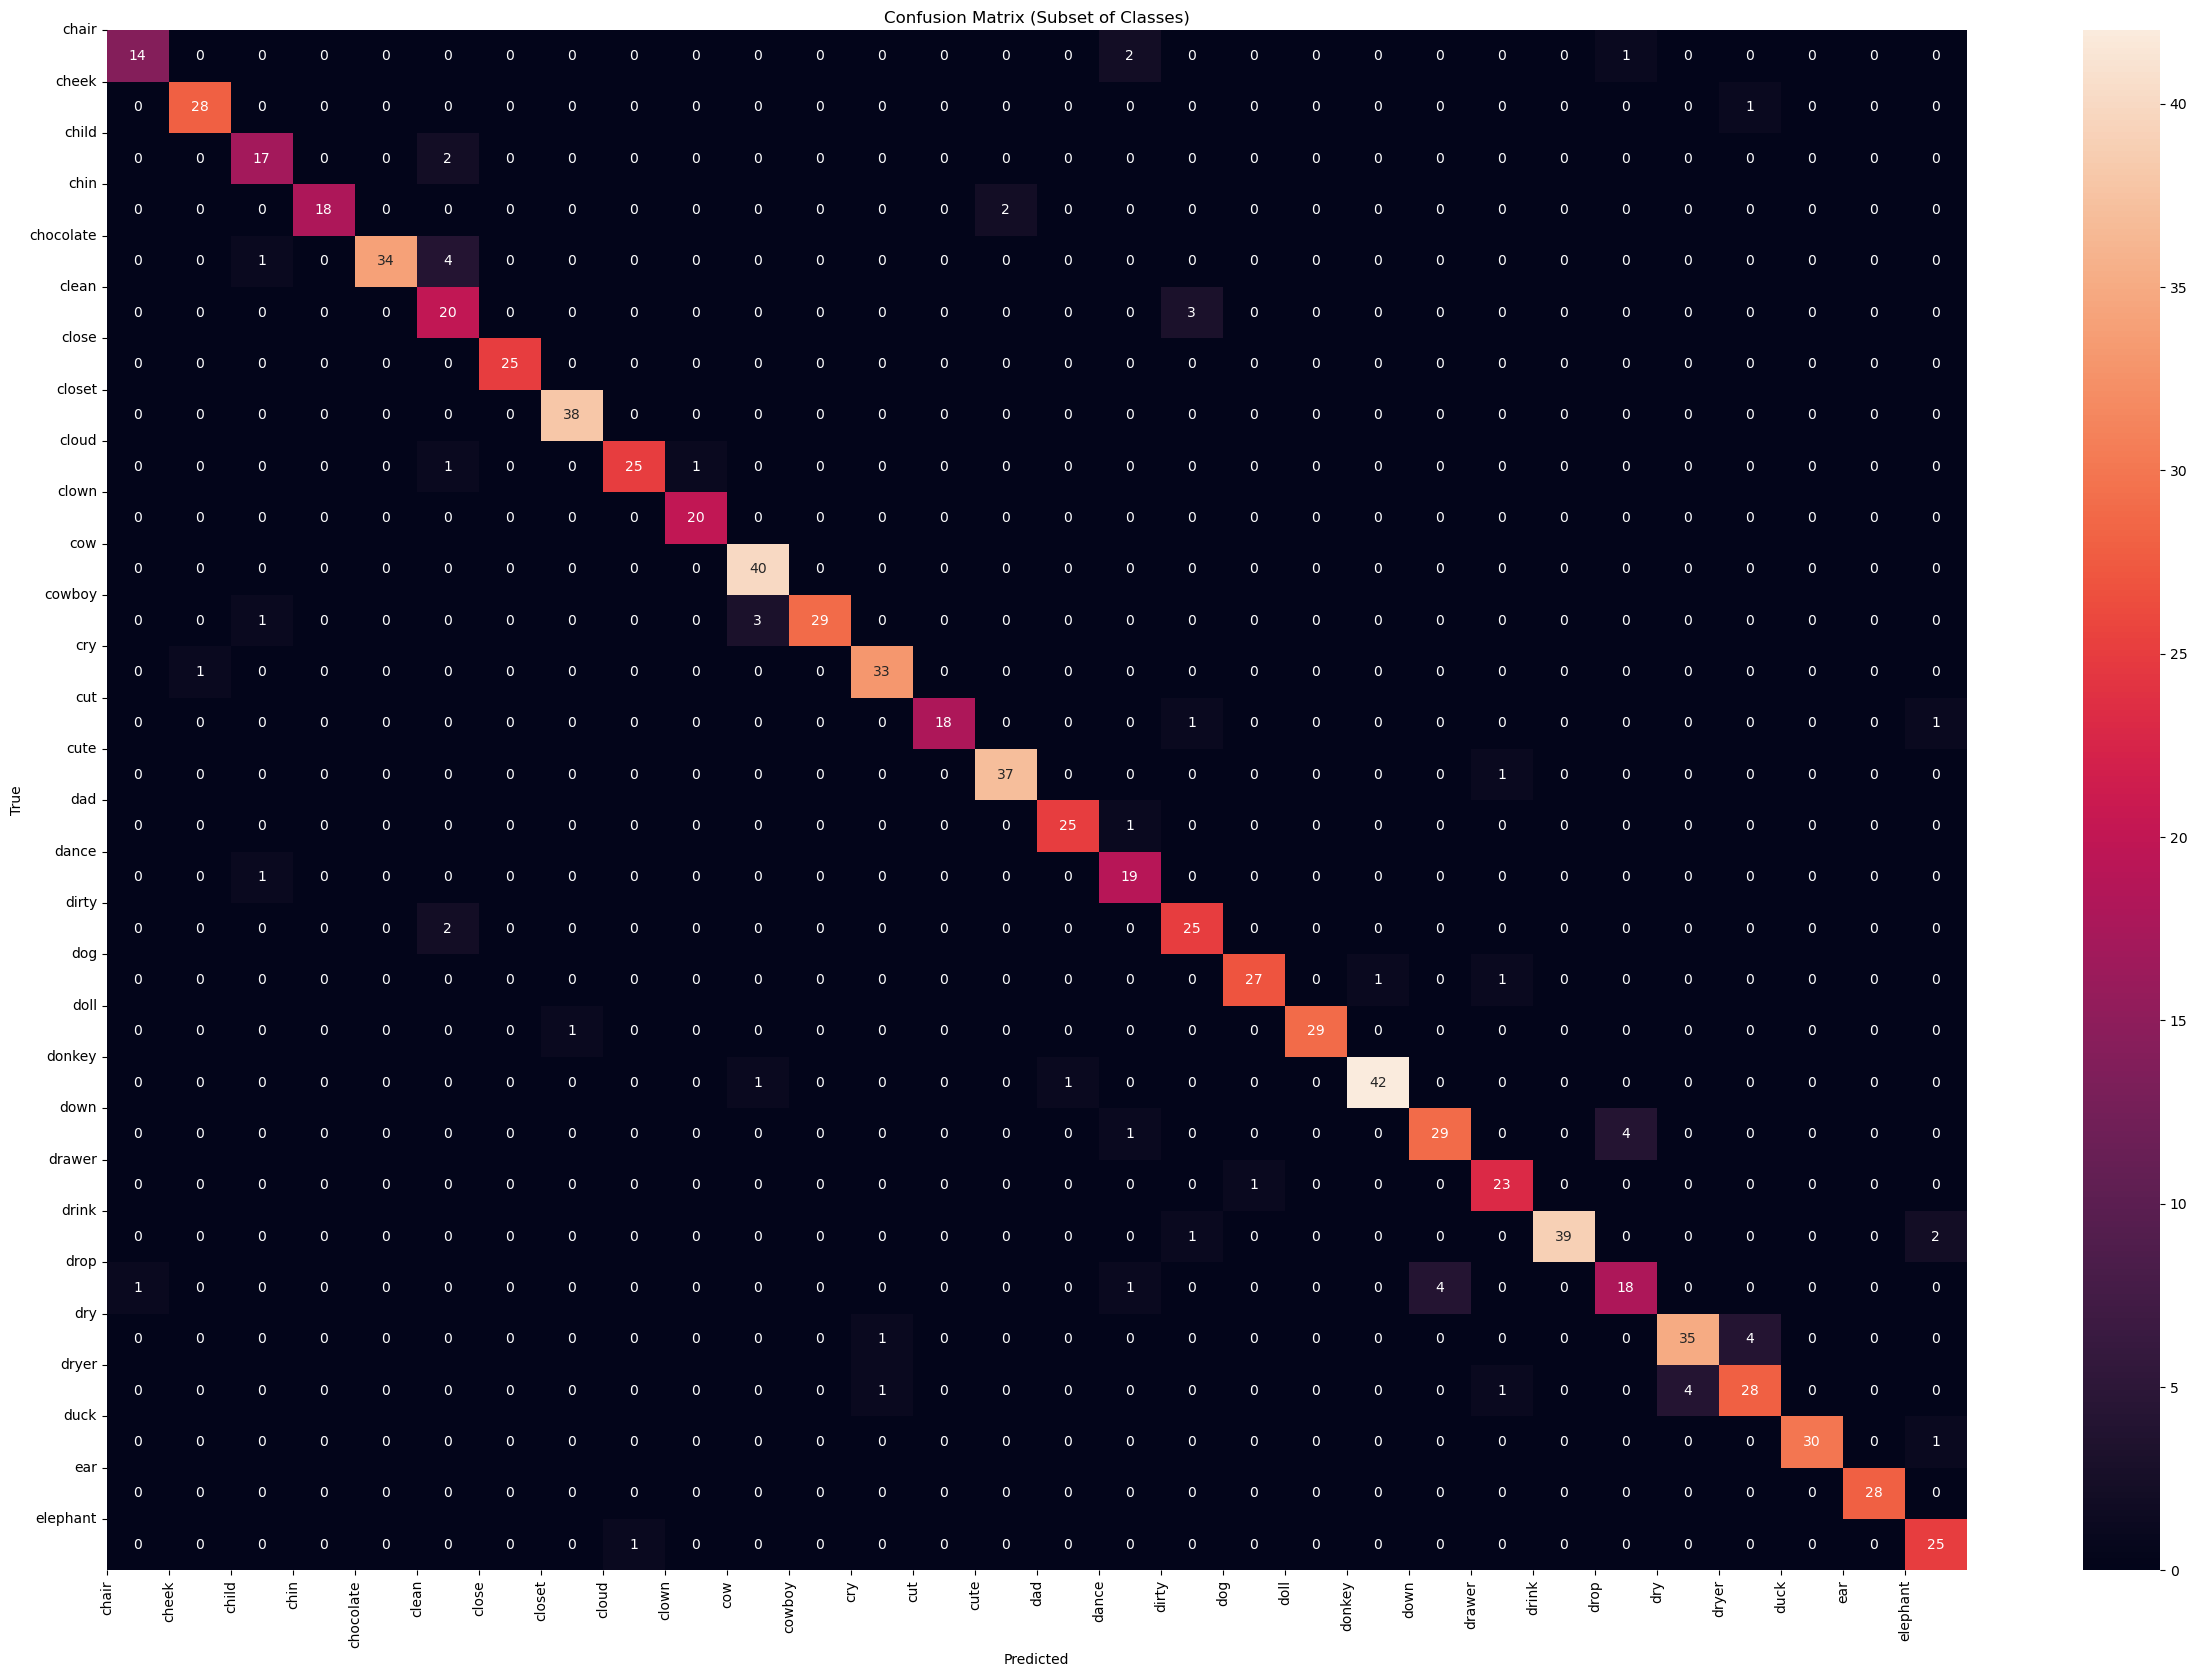

In [ ]:
def draw_confusion_matrix_subset(subset_classes):
    # Obtain predicted labels from the model
    y_pred = np.argmax(model.predict(test_ds), axis=-1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Filter the confusion matrix for the subset of classes
    subset_cm = cm[subset_classes][:,subset_classes]
    subset_labels = [labels[i] for i in subset_classes]

    # Create a heatmap of the confusion matrix for the subset of classes
    plt.figure(figsize=(30, 20))
    sns.heatmap(subset_cm, annot=True)

    # Add labels, title, and axis ticks
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Subset of Classes)")
    plt.xticks(np.arange(len(subset_labels)), subset_labels, rotation=90)
    plt.yticks(np.arange(len(subset_labels)), subset_labels, rotation=0)
    plt.savefig('cm.png')
    # Show the plot
    plt.show()

draw_confusion_matrix_subset(list(range(40,70)))